In [1]:
import numpy as np
import gym
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v0')

In [23]:
env.reset()
state, reward,done, _ = env.step(0)

In [20]:
theta = np.random.rand(4,2)

In [5]:
state

array([-0.01259954, -0.18921359,  0.04955248,  0.30708925])

In [21]:
w = np.random.rand(4,2)

In [24]:
v = np.dot(state,w)

In [8]:
v

array([ 0.05341572, -0.0135656 ])

#### Analysis functions

In [3]:
def check_solve(R):
    l = 100
    for i in range(l,len(R)):
        if np.mean(R[i-l:i])>=195:
            print('Solved in {} steps.'.format(i-l))
            break
    print('Done!')

In [4]:
def opt(n_episodes,alpha,gamma):
    data = {'total_reward':[],'av_reward':[],'alpha':[],'gamma':[]}
    for i in alpha:
        for j in gamma:
            R = cp_play(n_episodes,i,j)
            data['av_reward']+=[np.mean(R)]
            data['total_reward']+=[np.sum(R)]
            data['alpha']+=[i]
            data['gamma']+=[j]
    return pd.DataFrame(data).sort_values(['total_reward'],ascending=False)

In [5]:
def plot_rewards(R):
    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1)
    plt.plot(range(len(R)),R);
    plt.title('Average reward: {:.2f}'.format(np.mean(R)))
    plt.subplot(1,2,2)
    plt.title('Total reward: {:.0f}'.format(np.sum(R)))
    plt.plot(range(len(R)),np.cumsum(R));

### REINFORCE

In [6]:
def softmax(state,theta):
    a = np.matmul(state,theta)
    return np.exp(a)/np.sum(np.exp(a))

In [7]:
def policy(softmax_probs):
    #return np.random.choice([0,1],p=softmax_probs)
    if np.random.rand() < softmax_probs[0]:
        return 0
    else: return 1

In [8]:
def grads(action,softmax_probs):
    s = softmax_probs
    if action == 0:
        return np.array([s[1],-s[1]])[None,:]
    else: 
        return np.array([-s[0],s[0]])[None,:]

In [9]:
'''
Generate an episode
'''
def get_episode(theta):
    state = env.reset()
    episode = []
    while True:
        #env.render()
        s = softmax(state,theta)
        action = policy(s)
        next_state, reward, done, _ = env.step(action)
        
        episode.append((state,reward,action,s))
        state = next_state
        if done: break
    return episode

In [25]:
episode = get_episode(theta)
states = [item[0] for item in episode]
rewards = [item[1] for item in episode]
actions = [item[2] for item in episode]
softs = [item[3] for item in episode]

In [34]:
def cp_play(n_episodes,alpha,y):
    R = []
    episode_length = []
    theta = np.random.rand(4,2)
    w = np.random.rand(4,2)
    delta = 0
    v = []
    beta = 0.0001
    for i in range(n_episodes):
        episode = get_episode(theta)
        states = [item[0] for item in episode]
        rewards = [item[1] for item in episode]
        actions = [item[2] for item in episode]
        softs = [item[3] for item in episode]
        R.append(sum(rewards))
        episode_length.append(len(episode))
        grad = [grads(i,s) for i,s in zip(actions,softs)]
        
        for t in range(len(grad)):
            v = np.dot(states[t],w)
            delta = sum([(r*(y**j)) for j,r in enumerate(rewards[t:])]) - v
            w += beta*delta*states[t]
            theta += alpha*np.array(np.dot(states[t][None,:].T,grad[t])*delta)
        
    return R

CPU times: user 8.34 s, sys: 12.2 ms, total: 8.35 s
Wall time: 8.33 s


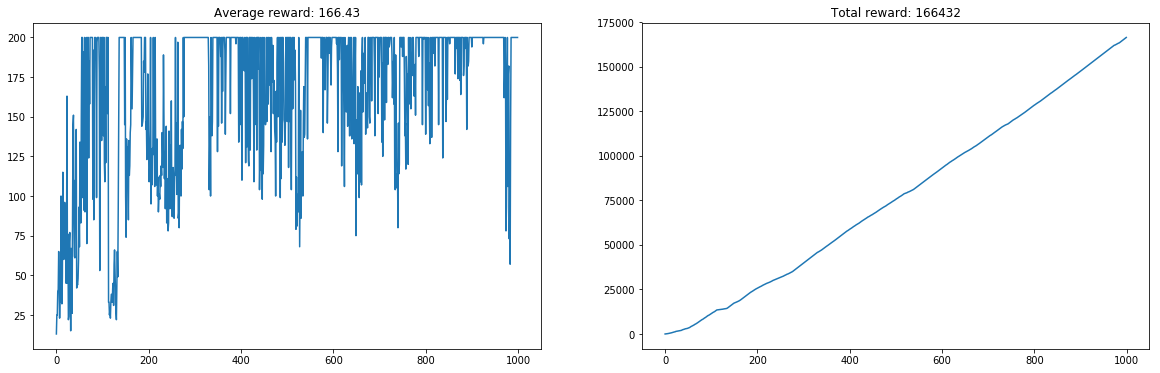

In [372]:
%%time
R = cp_play(1000,0.005,0.99)
plot_rewards(R)

In [373]:
check_solve(R)

Solved in 829 steps.
Done!


CPU times: user 7.12 s, sys: 3 µs, total: 7.12 s
Wall time: 7.12 s


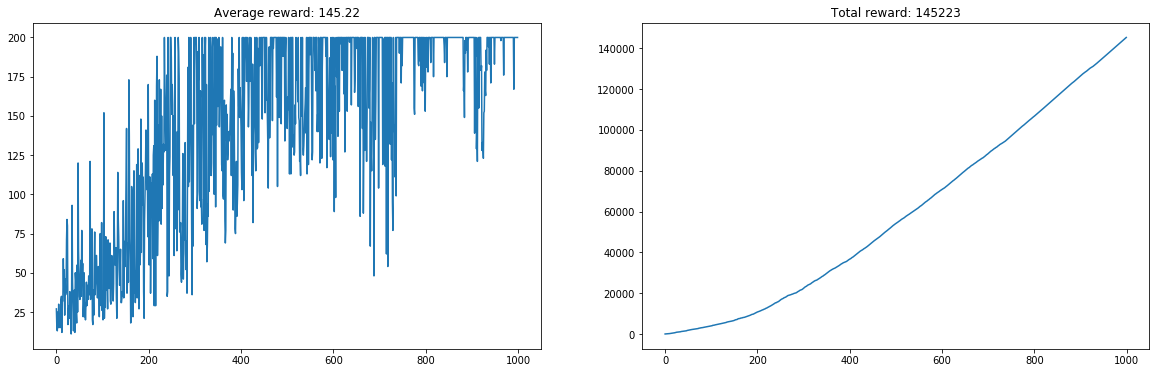

In [370]:
%%time
R = cp_play(1000,0.001,0.95)
plot_rewards(R)

In [371]:
check_solve(R)

Solved in 737 steps.
Done!


CPU times: user 17.2 s, sys: 16.1 ms, total: 17.3 s
Wall time: 17.2 s


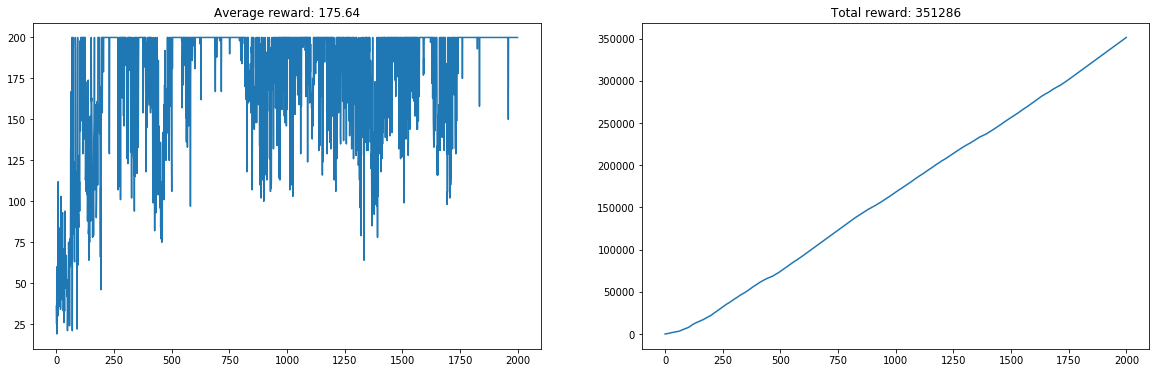

In [368]:
%%time
R = cp_play(2000,0.0025,0.99)
plot_rewards(R)

In [369]:
check_solve(R)

Solved in 566 steps.
Done!


---
#### Hyperparameters optimization

In [341]:
%%time
alpha = [0.01,0.008,0.006,0.004,0.002,0.001]
gamma = [0.99]
df = opt(1000,alpha,gamma)

CPU times: user 48.3 s, sys: 39.4 ms, total: 48.3 s
Wall time: 48.3 s


In [342]:
df

,total_reward,av_reward,alpha,gamma
2,178803.0,178.803,0.006,0.99
4,178048.0,178.048,0.002,0.99
5,165706.0,165.706,0.001,0.99
0,164319.0,164.319,0.010,0.99
1,154088.0,154.088,0.008,0.99
3,153023.0,153.023,0.004,0.99
